In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import project_tests as t

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download(['punkt', 'stopwords'])

import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline

df = pd.read_excel('/content/sample_data/WatchlistSampleData.xlsx')
df_content = pd.read_excel('/content/sample_data/stock_names.xlsx')

stc={'HEROMOTOCO': 2, 'BRITANNIA': 3, 'KOTAKBANK': 4, 'RELIANCE': 5, 'BAJAJ-AUTO': 6, 'TATACONSUM': 7, 'ITC': 8,\
     'WIPRO': 9, 'SUNPHARMA': 10, 'INDUSINDBK': 11, 'ICICIBANK': 12, 'JSWSTEEL': 13, 'APOLLOHOSP': 14, 'DIVISLAB': 15,\
     'LT': 16, 'COALINDIA': 17, 'TITAN': 18, 'ADANIPORTS': 19, 'NESTLEIND': 20, 'TECHM': 21, 'AXISBANK': 22, 'DRREDDY': 23,\
     'ULTRACEMCO': 24, 'HCLTECH': 25, 'CIPLA': 26, 'HDFC': 27, 'BHARTIARTL': 28, 'ADANIENT': 29, 'TATASTEEL': 30,\
     'MARUTI': 31, 'NTPC': 32, 'BAJAJFINSV': 33, 'EICHERMOT': 34, 'HDFCLIFE': 35, 'TATAMOTORS': 36, 'GRASIM': 37,\
     'BPCL': 38, 'SBIN': 39, 'POWERGRID': 40, 'INFY': 41, 'HINDALCO': 42, 'SBILIFE': 43, 'M&M': 44, 'ONGC': 45,\
     'BAJFINANCE': 46, 'HDFCBANK': 47, 'HINDUNILVR': 48, 'ASIANPAINT': 49, 'TCS': 50, 'UPL': 51}


# Show df to get an idea of the data
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,userId,stockId,holding,stkid
0,C1,BHARTIARTL,3.0,28
1,C1,POWERGRID,1.0,40
2,C1,ICICIBANK,3.0,12
3,C1,ASIANPAINT,3.0,49
4,C1,BRITANNIA,3.0,3


In [194]:
pip install project-test

In [195]:
# Show df_content to get an idea of the data
df_content.head()

,Stocknames,Sector,stkid
0,BRITANNIA,Consumer Food,1
1,INFY,IT Services & Consulting,2
2,KOTAKBANK,Bank - Private,3
3,DRREDDY,Pharmaceuticals & Drugs,4
4,WIPRO,IT Services & Consulting,5


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>



In [196]:
user_article = df.groupby('userId')['stockId'].count().values

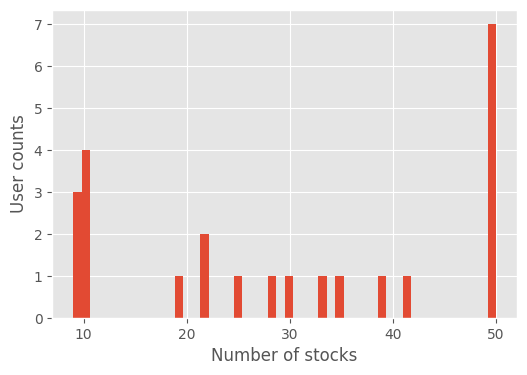

In [197]:
plt.style.use('ggplot')
plt.figure(figsize=(6,4))
plt.hist(user_article, bins=50)
plt.xlabel('Number of stocks', fontsize=12)
plt.ylabel('User counts', fontsize=12)
plt.show()

In [198]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(user_article) # 50% of individuals interact with _3_ number of articles or fewer.
max_views_by_user = np.max(user_article) # The maximum number of user-article interactions by any 1 user is _364_.

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [199]:
df['userId'].nunique()

24

In [200]:
len(df)

1310

In [201]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` the cells below  find the most viewed **stocks**, as well as how often it was viewed.  

In [202]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal
max_views = 937 # The most viewed article in the dataset was viewed how many times?

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

we don't actually have ratings for whether a user liked an stock or not.  We only know that a user has interacted with stock.  In these cases, the popularity of stock can really only be based on how often stock was interacted with.

The function below to return the **n** top STOCKS ordered with most interactions as the top.

In [203]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    '''
    top_articles = df['stockId'].value_counts().index[:n].tolist()

    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    '''
    top_articles = df['userId'].value_counts().index[:n].tolist()
    top_articles = [str(x) for x in top_articles]

    return top_articles # Return the top article ids

In [204]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['HINDALCO', 'HDFC', 'HDFCLIFE', 'DRREDDY', 'ULTRACEMCO', 'ADANIPORTS', 'NESTLEIND', 'TATAMOTORS', 'WIPRO', 'POWERGRID']
['C81', 'C14', 'C15', 'C16', 'C17', 'C19', 'C10', 'C2', 'C1', 'C4']


In [205]:
# Testing  function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_15 = get_top_articles(15)


print(top_15)


['HINDALCO', 'HDFC', 'HDFCLIFE', 'DRREDDY', 'ULTRACEMCO', 'ADANIPORTS', 'NESTLEIND', 'TATAMOTORS', 'WIPRO', 'POWERGRID', 'LT', 'BAJFINANCE', 'UPL', 'ADANIENT', 'SBILIFE']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.`  the function below  is to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**.

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [206]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix

    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with
    an article and a 0 otherwise
    '''
    # Create user item matrix
    user_item = df.groupby(['stockId', 'userId'])['stkid'].count().unstack()

    # Turn NAN into 0s and others into 1s
    user_item = 1 - user_item.isna().astype(int)

    return user_item # return the user_item matrix

user_item = create_user_item_matrix(df)


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

Use the tests to test your function.

In [207]:
def find_similar_users(userId, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered

    '''

    # compute similarity of each user to the provided user
    user_item=user_item.transpose()
    print("user id : ",userId)
    print(user_item)
    print("user_item.loc[userId]: ",user_item.loc[userId])

    similarity = user_item.loc[userId].dot(user_item.T)
    # sort by similarity
    similarity = similarity.sort_values(ascending=False)

    # create list of just the ids
    most_similar_users = similarity.keys().tolist()
    # remove the own user's id
    most_similar_users.remove(userId)

    return most_similar_users # return a list of the users in order from most to least similar


In [208]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users("C10")[:10]))
print("The 3 most similar users to user 9 are: {}".format(find_similar_users("C9")[:3]))

user id :  C10
stockId  ADANIENT  ADANIPORTS  APOLLOHOSP  ASIANPAINT  AXISBANK  BAJAJ-AUTO  \
userId                                                                        
C1              1           1           1           1         0           1   
C10             1           1           1           1         1           1   
C11             0           0           0           0         1           1   
C12             0           0           0           0         1           0   
C13             0           1           0           0         0           0   
C14             1           1           1           1         1           1   
C15             1           1           1           1         1           1   
C16             1           1           1           1         1           1   
C17             1           1           1           1         1           1   
C18             1           0           0           0         1           1   
C19             1           1        

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user.

In [209]:
def get_stock_names(stockId, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the title column)
    '''
    stock_names = df['stockId'].drop_duplicates().tolist()

    return stock_names # Return the article names associated with list of article ids




def get_user_stock(userId, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the doc_full_name column in df_content)

    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    n=user_item["C1"].tolist()
    user_item=user_item.transpose()
    l=user_item.columns.values.tolist()

    k=""
    j=-1
    for i in n:
        j+=1
        if i!=0:
            k+=str(l[j])+","
    k=k.split(",")
    l=""
    for i in k:
        if i!='':
            l+=str(stc[i])+","
    l=l[:-1]
    l=l.split(",")
    return l,k #stock_ids, return the ids and names


def user_user_recs(userId, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m
    and ends exceeding m, the last items are chosen arbitrarily

    '''
    # Find a list of the articles that have been seen by the user
    stock_ids = get_stock_names(userId)

    # Find similar users
    similar_user_ids = find_similar_users(userId)

    # Find recommendations
    recs = []
    for similar_user_id in similar_user_ids:
        similar_user_stock_ids, _ = get_user_stock(similar_user_id)
        for stock_id in similar_user_stock_ids:
            if stock_id not in stock_ids:
                recs.append(stock_id)
            if len(recs) >= m:
                break
        if len(recs) >= m:
            break

    return recs # return your recommendations for this user_id

In [210]:
# Check Results
get_stock_names(user_user_recs("C1", 10)) # Return 10 recommendations for user 1

user id :  C1
stockId  ADANIENT  ADANIPORTS  APOLLOHOSP  ASIANPAINT  AXISBANK  BAJAJ-AUTO  \
userId                                                                        
C1              1           1           1           1         0           1   
C10             1           1           1           1         1           1   
C11             0           0           0           0         1           1   
C12             0           0           0           0         1           0   
C13             0           1           0           0         0           0   
C14             1           1           1           1         1           1   
C15             1           1           1           1         1           1   
C16             1           1           1           1         1           1   
C17             1           1           1           1         1           1   
C18             1           0           0           0         1           1   
C19             1           1         

['BHARTIARTL',
 'POWERGRID',
 'ICICIBANK',
 'ASIANPAINT',
 'BRITANNIA',
 'BPCL',
 'BAJAJ-AUTO',
 'DRREDDY',
 'ITC',
 'HINDALCO',
 'HINDUNILVR',
 'HDFC',
 'NESTLEIND',
 'SUNPHARMA',
 'ADANIENT',
 'KOTAKBANK',
 'BAJAJFINSV',
 'MARUTI',
 'TITAN',
 'TATASTEEL',
 'TCS',
 'APOLLOHOSP',
 'COALINDIA',
 'BAJFINANCE',
 'LT',
 'RELIANCE',
 'WIPRO',
 'INFY',
 'GRASIM',
 'TATAMOTORS',
 'HDFCLIFE',
 'TATACONSUM',
 'INDUSINDBK',
 'M&M',
 'DIVISLAB',
 'HCLTECH',
 'HEROMOTOCO',
 'UPL',
 'ADANIPORTS',
 'JSWSTEEL',
 'NTPC',
 'SBILIFE',
 'TECHM',
 'ULTRACEMCO',
 'ONGC',
 'CIPLA',
 'SBIN',
 'AXISBANK',
 'HDFCBANK',
 'EICHERMOT',
 nan]

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [211]:
def get_top_sorted_users(userId, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    user_item - (pandas dataframe) matrix of users by articles:
            1's when a user has interacted with an article, 0 otherwise


    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u

    Other Details - sort the neighbors_df by the similarity and then by number of interactions where
                    highest of each is higher in the dataframe

    '''
    similar_user_ids = find_similar_users(userId)
    neighbors_dict = {'neighbor_id': [], 'similarity': [], 'num_interactions': []}
    user_item=user_item.transpose()
    for similar_user_id in similar_user_ids:
        neighbors_dict['neighbor_id'].append(similar_user_id)
        neighbors_dict['similarity'].append(user_item.loc[userId].dot(user_item.loc[similar_user_id]))
        neighbors_dict['num_interactions'].append(user_item.loc[similar_user_id].sum())

    neighbors_df = pd.DataFrame(neighbors_dict).sort_values(['similarity', 'num_interactions'], ascending=[False, False])

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(userId, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions
    before choosing those with fewer total interactions.

    '''
    # Find a list of the articles that have been seen by the user
    stock_ids, _ = get_user_stock(userId)

    # Find similar users
    similar_user_ids = get_top_sorted_users(userId)['neighbor_id'].tolist()

    # Find recommendations
    recs = []
    for similar_user_id in similar_user_ids:
        similar_user_stock_ids, _ = get_user_stock(similar_user_id)
        for StockId in similar_user_stock_ids:
            if StockId not in stock_ids:
                recs.append(StockId)
            if len(recs) >= m:
                break
        if len(recs) >= m:
            break

    rec_names = get_stock_names(recs)

    return recs, rec_names

In [212]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2("C10", 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

user id :  C10
stockId  ADANIENT  ADANIPORTS  APOLLOHOSP  ASIANPAINT  AXISBANK  BAJAJ-AUTO  \
userId                                                                        
C1              1           1           1           1         0           1   
C10             1           1           1           1         1           1   
C11             0           0           0           0         1           1   
C12             0           0           0           0         1           0   
C13             0           1           0           0         0           0   
C14             1           1           1           1         1           1   
C15             1           1           1           1         1           1   
C16             1           1           1           1         1           1   
C17             1           1           1           1         1           1   
C18             1           0           0           0         1           1   
C19             1           1        

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [213]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users("C1").iloc[0]['neighbor_id'] # Find the user that is most similar to user 1
user131_10th_sim = get_top_sorted_users("C13").iloc[10]['neighbor_id'] # Find the 10th most similar user to user 131

user id :  C1
stockId  ADANIENT  ADANIPORTS  APOLLOHOSP  ASIANPAINT  AXISBANK  BAJAJ-AUTO  \
userId                                                                        
C1              1           1           1           1         0           1   
C10             1           1           1           1         1           1   
C11             0           0           0           0         1           1   
C12             0           0           0           0         1           0   
C13             0           1           0           0         0           0   
C14             1           1           1           1         1           1   
C15             1           1           1           1         1           1   
C16             1           1           1           1         1           1   
C17             1           1           1           1         1           1   
C18             1           0           0           0         1           1   
C19             1           1         

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Collaborative flitering does not work for cold start problem. If given a new user, we can use get_top_article_ids( ) function to make recommendations, which means we will recommend the most popular articles to new users. It is reasonable to assume that a new user will like what everyone else like. Thus, rank based recommendations for new users makes sense.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [214]:
new_user = 'C190'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to
new_user_recs = get_top_article_ids(10) # Your recommendations here

In [215]:
new_user_recs= ['DRREDDY','CIPLA','SUNPHARMA','DIVISLAB']
print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

#### Combine the content

In [216]:
df_content.fillna("", inplace=True)
df_cont = pd.read_excel('/content/sample_data/fullnamestocks.xlsx')
# Give a higher weight on 'doc_full_name'
df_content['Stocknames'] = (df_cont['Full Name'] + " ") * 2 + \
                    df_content['Sector']
df_content.head()

,Stocknames,Sector,stkid
0,Britannia Industries Limited Britannia Industr...,Consumer Food,1
1,Infosys Limited Infosys Limited IT Services & ...,IT Services & Consulting,2
2,Kotak Mahindra Bank Limited Kotak Mahindra Ban...,Bank - Private,3
3,Dr. Reddy's Laboratories Limited Dr. Reddy's L...,Pharmaceuticals & Drugs,4
4,Wipro Limited Wipro Limited IT Services & Cons...,IT Services & Consulting,5


#### Implement NMF

For NMF (non-negative matrix factorization), we need to obtain a design matrix. Here, we apply TfidfVectorizer to the combined text content. The transformation will return a matrix of size (documents x features). To reduce the size of the matrix and speed up computation, we set the maximum feature size to 5000, which will take the top 5000 best features that can contribute to our model.

In [229]:
def tokenize(text):
    '''
    INPUT:
    text - (str) raw text data

    OUTPUT:
    tokens - (list) a list of strings after tokenization

    Description:
    Transform raw text data to a bag of words
    '''
    # Remove websites and email addresses
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)

    # Normalize case and remove punctuation
    text = re.sub("[^a-zA-Z]", " ", text.lower())

    # Tokenize text
    tokens = word_tokenize(text)

    # Stem and remove stop words
    tokens = [PorterStemmer().stem(word)
              for word in tokens if word not in stopwords.words("english")]

    # Make sure there is no one letter words
    tokens = [word for word in tokens if len(word) > 1]

    return tokens
df_content= df_content.head(50)
df_content['Stocknames'].fillna('', inplace=True)
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, max_features=5000)
tfidf = tfidf_vectorizer.fit_transform(df_content['Stocknames'])

0     Britannia Industries Limited Britannia Industr...
1     Infosys Limited Infosys Limited IT Services & ...
2     Kotak Mahindra Bank Limited Kotak Mahindra Ban...
3     Dr. Reddy's Laboratories Limited Dr. Reddy's L...
4     Wipro Limited Wipro Limited IT Services & Cons...
5     Tata Consumer Products Limited Tata Consumer P...
6                   ITC Limited ITC Limited Diversified
7     Mahindra & Mahindra Limited Mahindra & Mahindr...
8     Nestlé India Limited Nestlé India Limited Cons...
9     Titan Company Limited Titan Company Limited Di...
10    Bharti Airtel Limited Bharti Airtel Limited Te...
11    Tata Consultancy Services Limited Tata Consult...
12    Apollo Hospitals Enterprise Limited Apollo Hos...
13     Bajaj Finance Limited Bajaj Finance Limited NBFC
14     JSW Steel Limited JSW Steel Limited Iron & Steel
15    Maruti Suzuki India Limited Maruti Suzuki Indi...
16    Hindustan Unilever Limited Hindustan Unilever ...
17    Tech Mahindra Limited Tech Mahindra Limite

<ipython-input-229-9d9bb5c098d6>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['Stocknames'].fillna('', inplace=True)


In [230]:
# Obtain a NMF model
num_topics = 20
nmf = NMF(n_components=num_topics, random_state=0)
nmf_features = nmf.fit_transform(tfidf)

#### Generate NMF topics

In [231]:
def get_nmf_topics(vectorizer=tfidf_vectorizer, model=nmf, n_top_words=20):
    '''
    INPUT:
    vectorizer - (object) an object that vectorize documents
    model - (object) a model built for topic extraction
    n_top_words - (int) the number of top words in each topic

    OUTPUT:
    word_df - (pandas datafram) top words for each topic

    Description:
    Display the latent article topics using NMF
    '''
    feat_names = vectorizer.get_feature_names_out()

    word_dict = {};
    for i in range(num_topics):
        # Obtain the largest values for each topic, and add the words they map to into the dictionary
        words_ids = model.components_[i].argsort()[:-n_top_words-1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic ' + '{:02d}'.format(i+1)] = words;

    word_df = pd.DataFrame(word_dict)

    return word_df

get_nmf_topics()

,Topic 01,Topic 02,Topic 03,Topic 04,Topic 05,Topic 06,Topic 07,Topic 08,Topic 09,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
0,consult,bank,financ,industri,insur,steel,mahindra,bajaj,motor,india,enterpris,laboratori,oil,ntpc,hindustan,upl,cement,airtel,titan,toubro
1,servic,privat,hous,grasim,life,iron,tech,auto,tata,nestl,adani,divi,corpor,power,unilev,itc,ultratech,bharti,compani,larsen
2,infosi,icici,develop,britannia,compani,jsw,kotak,finserv,eicher,coal,hospit,reddi,natur,distribut,product,cipla,hcl,telecommun,jewelleri,pesticid
3,wipro,indusind,corpor,hindalco,hdfc,tata,manufactur,limit,trade,maruti,paint,dr,ga,gener,person,limit,technolog,provid,diamond,agrochem
4,limit,axi,limit,limit,asian,hindalco,truck,coal,consum,suzuki,apollo,pharmaceut,petroleum,limit,household,diversifi,hvc,servic,limit,limit
5,tata,limit,motocorp,relianc,sbi,limit,auto,financ,limit,food,limit,wheeler,bharat,grid,limit,engin,lcv,limit,sbi,hero
6,coal,state,hero,pharmaceut,health,industri,limit,nbfc,product,consum,special,drug,explor,sbi,consum,construct,limit,motocorp,motocorp,motocorp
7,tech,kotak,privat,sun,paint,motocorp,automobil,pharmaceut,coffe,grid,econom,limit,product,pharmaceut,tea,motocorp,automobil,hero,hero,invest
8,hospit,public,nbfc,consum,limit,hero,consult,drug,tea,state,port,automobil,relianc,corpor,coffe,hero,eicher,hospit,invest,nestl
9,india,india,invest,food,distribut,asian,servic,sun,hvc,limit,zone,sun,limit,drug,tata,grasim,motor,invest,gener,asian


#### Compute document similarity

In [232]:
norm_features = normalize(nmf_features)

nmf_feat_df = pd.DataFrame(norm_features, index=df_cont['Full Name'].apply(lambda x: x.lower()).tolist())

def get_similar_articles(article_name, n_top, vectorizer=tfidf_vectorizer, model=nmf, feat_df=nmf_feat_df):
    '''
    INPUT:
    article_name - (int) an article name to query
    n_top - (int) the number of similar articles to return
    vectorizer - (object) an object that vectorize documents
    model - (object) a model built for topic extraction
    feat_df - (pandas dataframe) similarity matrix of documents by topics

    OUTPUT:
    similar_articles - (list) top n_top similar articles

    Description:
    Find top similar articles for a given article
    '''
    # For any article that is not included in 'df_content'
    if stock_name not in feat_df.index:
        test_feature_mat = vectorizer.transform([stock_name])
        test_output = model.transform(test_feature_mat)
        # Calculate the cosine similarities
        similarities = feat_df.dot(normalize(test_output).T)
        similar_stock = similarities.squeeze().sort_values(ascending=False).iloc[:n_top]
    else:
        similarities = feat_df.dot(feat_df.loc[stock_name])
        similar_stock = similarities.sort_values(ascending=False).iloc[1:n_top+1]

    return similar_stock

#### Make recommendations

In [ ]:
def make_content_recs(user_id=None,
                      article_list=None,
                      n_recs=10,
                      user_item=user_item,
                      df=df,
                      vectorizer=tfidf_vectorizer,
                      model=nmf,
                      feat_df=nmf_feat_df):
    '''
    INPUT:
    user_id - (int) a user id
    article_list - (list) a list of article ids (from df)
    n_recs - (int) the number of recommendations to make
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise
    vectorizer - (object) an object that vectorize documents
    model - (object) a model built for topic extraction

    OUTPUT:
    rec_names - (list) a list of recommended article names

    Description:
    Recommend a user n_recs articles similar to the ones he/she has already seen
    '''
    if not stock_list:
        # Recommend top articles for a new user
        if user_id not in user_item.index:
            rec_names = get_top_stock(n_recs)
            return rec_names
        else:
            # Get the articles the user has interacted with
            _, seen_stock_names = get_user_stock(userId)
    else:
        seen_stock_ids = stock_list
        seen_stock_names = get_stock_names(seen_stock_ids)

    # Find n_recs similar articles in df_content for each article the user has seen
    similar_articles = pd.Series([])
    for article_name in seen_stock_names:
        sims = get_similar_stock(article_name, n_recs)
        similar_articles = similar_articles.append(sims)

    rec_names = similar_articles.sort_values(ascending=False).drop_duplicates().index.tolist()[:n_recs]

    return rec_names

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Our content based recommender is designed based on the assumption that similar articles should have similar topics. To compute the similarities between ariticles, we perform the followeing steps:**
1. Combine **doc_body**, **doc_description**, or **doc_full_name** into a single document for each article. A higher weight is given to **doc_full_name** to emphasizes the key words in the article name by increasing their frequency.
2. Convert the combined raw documents to a matrix of TF-IDF features using a self-defined tokenize function.
3. Apply non-negative matrix factorization (NMF) to find latent topics for the collection of articles. This step will generate an article-topic matrix.
4. Calculate the cosine similarities between articles from the article-topic matrix as the article similarties.

**Our strategy to recommend a user n articles can be summarized as:**
1. Get a list of articles the user has already seen.
2. For each seen article, find n most similar articles.
3. Assemble all these articles in a list and sort them in descending order by their similarity values.
4. Select the top n articles from this list as the recommendations.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [ ]:
# make recommendations for a brand new user
print("The top 10 recommendations for a new user are the following article names:")
make_content_recs(user_id=0)

In [ ]:
# make a recommendations for a user who only has interacted with article id '1427.0'
print("The top 10 recommendations for a user who only has interacted with article {} are the following article names:".format(get_article_names(article_ids=['1427.0'])))
make_content_recs(article_list=['1427.0'])

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook.

In [ ]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [ ]:
# quick look at the matrix
user_item_matrix.head()

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [ ]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**In this case, we have a matrix without missing values, which makes it feasible to perform SVD. If the matrix includes missing values, then we have to use FunkSVD instead.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [ ]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below:

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [ ]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe

    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids

    '''
    # Create user-item matrices with 1's and 0's for the training and testing dataframe
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    train_idx = set(user_item_train.index.tolist())
    test_idx = set(user_item_test.index.tolist())
    match_idx = list(train_idx.intersection(test_idx))

    train_arts = set(user_item_train.columns.tolist())
    test_arts = set(user_item_test.columns.tolist())
    match_cols = list(test_arts.intersection(train_arts))

    user_item_test = user_item_test.loc[match_idx, match_cols]

    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [ ]:
# Find the number of users we can make predictions for in the test set
user_item_test.shape[0]

In [ ]:
# Find the number of users in the test set we are unable to make predictions for because of the cold start problem
len(test_idx) - user_item_test.shape[0]

In [ ]:
# Find the number of movies we can make predictions for in the test set
user_item_test.shape[1]

In [ ]:
# Find the number of movies in the test set we are unable to make predictions for because of the cold start problem
len(test_arts) - user_item_test.shape[1]

In [ ]:
# Replace the values in the dictionary below
a = 662
b = 574
c = 20
d = 0


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [ ]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [ ]:
# Find row and column indices for test user ids and article ids in the training set
row_idx = user_item_train.index.isin(test_idx)
col_idx = user_item_train.columns.isin(test_arts)

In [ ]:
# Get u_test and vt_test
u_test = u_train[row_idx, :]
vt_test = vt_train[:, col_idx]

In [ ]:
num_latent_feats = np.arange(10,700+10,20)

accuracy_train = []
accuracy_test = []

precision_train = []
precision_test = []

recall_train = []
recall_test = []

f1_train = []
f1_test = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_k, vt_test_k = u_test[:, :k], vt_test[:k, :]

    # take dot product
    user_item_train_pred = np.clip(np.around(u_train_k.dot(s_train_k).dot(vt_train_k)), 0, 1)
    user_item_test_pred = np.clip(np.around(u_test_k.dot(s_train_k).dot(vt_test_k)), 0, 1)

    # compute precision values
    precision_train.append(precision_score(np.array(user_item_train).reshape(-1,), user_item_train_pred.reshape(-1,)))
    precision_test.append(precision_score(np.array(user_item_test).reshape(-1,), user_item_test_pred.reshape(-1,)))

    # compute recall values
    recall_train.append(recall_score(np.array(user_item_train).reshape(-1,), user_item_train_pred.reshape(-1,)))
    recall_test.append(recall_score(np.array(user_item_test).reshape(-1,), user_item_test_pred.reshape(-1,)))

    # compute f1 score
    f1_train.append(f1_score(np.array(user_item_train).reshape(-1,), user_item_train_pred.reshape(-1,)))
    f1_test.append(f1_score(np.array(user_item_test).reshape(-1,), user_item_test_pred.reshape(-1,)))

In [ ]:
plt.plot(num_latent_feats, precision_train, label='Train')
plt.plot(num_latent_feats, precision_test, label='Test')
plt.xlabel('Number of latent features');
plt.ylabel('Precision');
plt.legend();

In [ ]:
plt.plot(num_latent_feats, recall_train, label='Train')
plt.plot(num_latent_feats, recall_test, label='Test')
plt.xlabel('Number of latent features');
plt.ylabel('Recall');
plt.legend();

In [ ]:
plt.plot(num_latent_feats, f1_train, label='Train')
plt.plot(num_latent_feats, f1_test, label='Test')
plt.xlabel('Number of latent features');
plt.ylabel('F1');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles?

**Due to the class imbalance of 0's and 1's in the training and testing datasets, we use precision, recall and f1 score to demonstrate prediction performance instead of accuracy. It can be seen that the f1 score of the test set peaks at a low value with ~70 latent features. The low precision and recall values of the test set further show that SVD performs poorly towards making predictions for recommendations.**

**On the other hand, our test set only consists of 20 users. The fact that we can only evaluate an extremely small subset of users implies that our work might not generalize well to the population that we want to use our recommendation system on. A better way to evaluate recommendation systems is to set up an A/B test, where account-based users will be randomly assigned to a control group that receives recommendations using the current system, and an experimental group that receives recommendations using a new system. The number of users in each group should not be significantly different. After the experiment size is estimated, we then measure the average number of interactions by users in each group. We conduct a hypothesis test of whether there is difference in number of user interactions between the two systems. The new system will be deployed if the results are both statistically and practically significant.**

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])